In [ ]:
# I finally chose no class conditioning, as the class is not localy deductible

In [1]:
import numpy as np
print(np.__version__)

1.23.5


In [107]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import contextlib
import os
import librosa
import torch
import torchaudio
from scipy.signal import hilbert, butter, filtfilt
from scipy.interpolate import interp1d
import soundfile as sf
import random
from math import ceil
import IPython.display as ipd

DATA_PATH = r'C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2'

# Explore

In [3]:
def get_wav_files(data_path):
    wav_files = []
    
    # Traverse the directory tree
    for root, dirs, files in os.walk(data_path):
        
        for file in files:
            if file.endswith('.wav'):
                wav_files.append(os.path.join(root, file))
    
    return wav_files


In [4]:
len(get_wav_files(DATA_PATH))

433

In [5]:
wav_paths = get_wav_files(DATA_PATH)

In [6]:
durations = []
sample_rates = []

for path in wav_paths:
    with contextlib.closing(wave.open(path, 'r')) as wav_file:
        frames = wav_file.getnframes()  # number of frames
        rate = wav_file.getframerate()  # sample rate
        duration = frames / float(rate)  # length in seconds
        
        durations.append(duration)
        sample_rates.append(rate)

sample_rates = np.array(sample_rates)
durations = np.array(durations)

In [7]:
sample_rates.mean()

44100.0

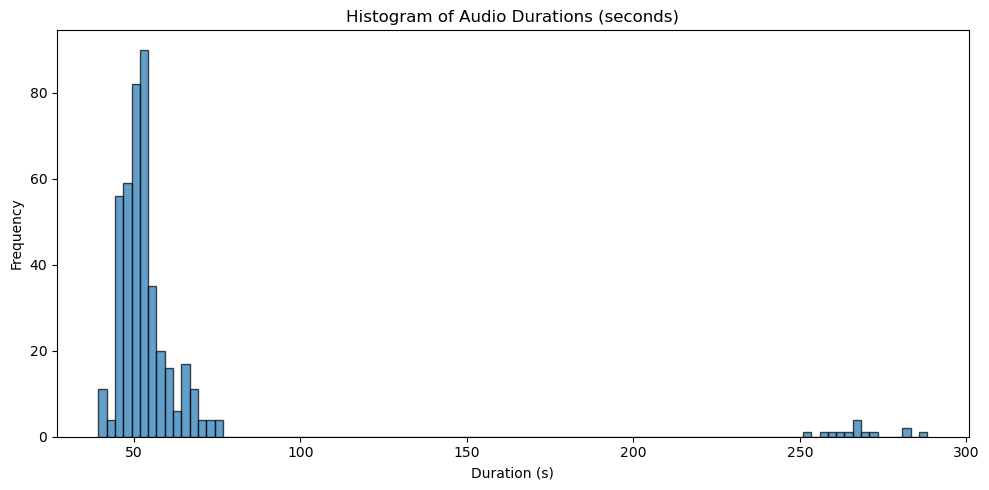

In [29]:
plt.figure(figsize=(10, 5))

plt.hist(durations, bins=100, edgecolor='black', alpha=0.7)
plt.title('Histogram of Audio Durations (seconds)')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [30]:
# Print the names of files with duration more than 100 seconds
for path, duration in zip(wav_paths, durations):
    if duration > 100:
        print(path)

C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VA-NR\VA-S-JH-VN0-NR-1.wav
C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VA-NR\VA-S-JH-VN0-NR-2.wav
C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VA-NR\VA-S-JH-VN0-NR-4.wav
C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VC-NR\VC-S-JH-VN0-NR-2.wav
C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VC-NR\VC-S-JH-VN0-NR-3.wav
C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VC-NR\VC-S-JH-VN0-NR-4.wav
C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VC-NR\VC-S-JH-VN0-NR-5.wav
C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VC-NR\VC-S-JH-VN0-NR-6.wav
C:\Users\adhem\Desktop\Music\Custom_VST\data\ARME-Virtuoso-Strings-2.2\SOLO\S-JH-VN1-NR\VN1-S-JH-VN0-NR-2.wav
C:\Users\adhem\Desktop\Mus

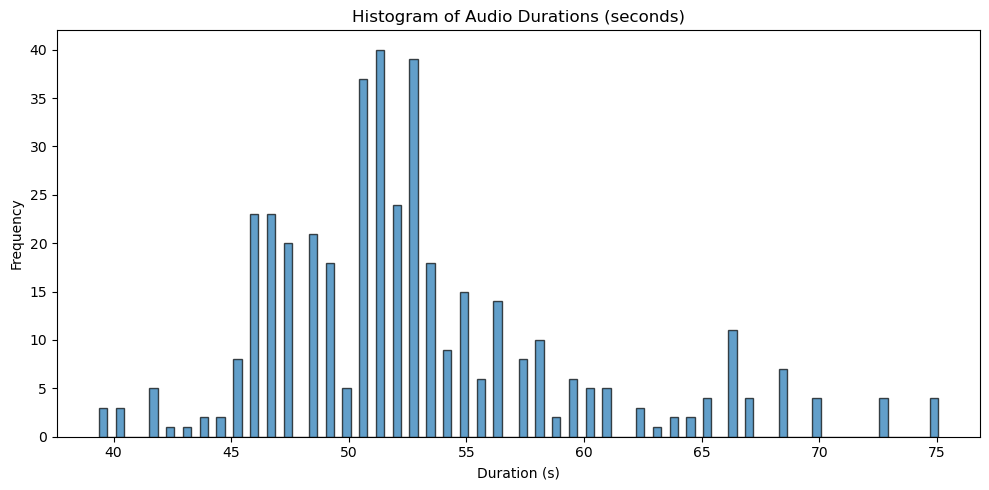

In [31]:
plt.figure(figsize=(10, 5))

plt.hist(durations[durations<100], bins=100, edgecolor='black', alpha=0.7)  # 10 times more bins
plt.title('Histogram of Audio Durations (seconds)')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Build Class

In [114]:
data_cfg = {
    'path': DATA_PATH,
    'sr': 22050,
    'sample_duration':8, # Seconds
    'latent_compression': 4**4,
    'envelope_detector':{
        'type': 'Max',
        'low_pass':400
        },
    'pitch_detector': {
        'n_fft': 4096,
        'hop_length': 1024,
        'fmin': 75,
        'fmax': 800,
        'threshold': 0.15,
        'win_length': None,  # Defaults to n_fft
        'window': 'hann',
        'center': True,
        'pad_mode': 'reflect'
    },
}

class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, **config):

        self.data_path = config['path']
        self.sr = config['sr']
        self.sample_duration = config['sample_duration']
        self.latent_compression = config['latent_compression']

        self.envelope_detector_config = config['envelope_detector']
        self.envelope_detector_type = self.envelope_detector_config.pop('type')
        if self.envelope_detector_type == 'hilbert':
            b, a = butter(N=5, Wn=self.envelope_detector_config['low_pass'] / (0.5 * self.sr), btype='low')
            self.envelope_detector_config['a'] = a
            self.envelope_detector_config['b'] = b
        

        self.pitch_detector_config = config['pitch_detector']


        self.wav_files = self._get_wav_files()
    
    def _get_wav_files(self):
        wav_files = []

        # Traverse the directory tree
        for root, dirs, files in os.walk(self.data_path):
            
            for file in files:
                if file.endswith('.wav'):
                    wav_files.append(os.path.join(root, file))
        
        return wav_files
    
    def _get_envelope(self, x):

        pad_length = (self.latent_compression - (len(x) % self.latent_compression)) % self.latent_compression
        if pad_length > 0:
            x = np.pad(x, (0, pad_length), mode='constant')
        
        # Envelope
        if self.envelope_detector_type == 'hilbert':
            x_envelope = filtfilt(self.envelope_detector_config['b'], self.envelope_detector_config['a'], x)
            x_envelope = hilbert(x_envelope)
            x_envelope = np.abs(x_envelope)
            x_envelope = x_envelope.reshape(-1, self.latent_compression)
            x_envelope = np.mean(x_envelope, axis=1)

        elif self.envelope_detector_type == 'RMS':
            x_envelope = x.reshape(-1, self.latent_compression)
            x_envelope = np.std(x_envelope, axis=1)*np.sqrt(2)

        elif self.envelope_detector_type == 'Max':
            x_envelope = x.reshape(-1, self.latent_compression)
            x_envelope = np.max(x_envelope, axis=1)
        
        
        return x_envelope


    
    def _get_pitch(self, x):
    
        # Extract pitch and magnitude arrays
        pitches, _ = librosa.piptrack(y=x, sr=self.sr, **self.pitch_detector_config)
        x_pitch = np.max(pitches, axis=0)
        
        # Interpolate
        original_len = len(x_pitch)
        target_len = ceil(len(x) / self.latent_compression)
        interpolator = interp1d(np.arange(original_len), x_pitch, kind='linear', fill_value="extrapolate")
        x_pitch = interpolator(np.linspace(0, original_len - 1, target_len))

        return x_pitch

    def __len__(self):
        return len(self.wav_files)

    def __getitem__(self, idx):
        wav_path = self.wav_files[idx]
        # waveform, sample_rate = torchaudio.load(wav_path) # Strange torch - numpy incompatibility
        waveform, sample_rate = sf.read(wav_path)
        waveform = torch.tensor(waveform, dtype=torch.float32)

        # Resample to self.sr if sample rates differ
        if sample_rate != self.sr:
            waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.sr)(waveform)

        # select a random part that has duration self.sample_duration
        num_samples = int(self.sample_duration * self.sr)
        start_idx = random.randint(0, waveform.size(0) - num_samples)
        waveform = waveform[start_idx:start_idx + num_samples]
        waveform_np = np.array(waveform)
        
        # Get the envelope and pitch
        x_envelope = self._get_envelope(waveform_np)
        x_pitch = self._get_pitch(waveform_np)

        # Return a dictionary with the waveform, envelope, and pitch
        return {
            'x': waveform,
            'x_envelope': torch.tensor(x_envelope),
            'x_pitch': torch.tensor(x_pitch)
        }
    
    def plot_item(self, i):
        # Get the item at index i
        item = self[i]
        
        # Extract waveform, envelope, and pitch
        waveform = item['x'].numpy()
        envelope = item['x_envelope'].numpy()
        pitch = item['x_pitch'].numpy()
        t = np.linspace(0, len(waveform) / self.sr, len(waveform))
        
        fig, axs = plt.subplots(2, 1, figsize=(10, 6))
        # Plot waveform and envelope together
        axs[0].plot(t, waveform, label='Waveform', alpha=0.7)
        axs[0].plot(t[::self.latent_compression], envelope, label='Envelope', color='orange', alpha=0.7)
        axs[0].set_title('Waveform and Envelope')
        axs[0].legend(loc='upper right')
        
        # Plot pitch (select the pitch values where they are detected)
        axs[1].plot(t[::self.latent_compression], pitch)
        axs[1].set_title('Pitch')
        
        plt.tight_layout()
        plt.show()
        ipd.Audio(waveform, rate=self.sr)

In [115]:
DATASET = AudioDataset(**data_cfg)

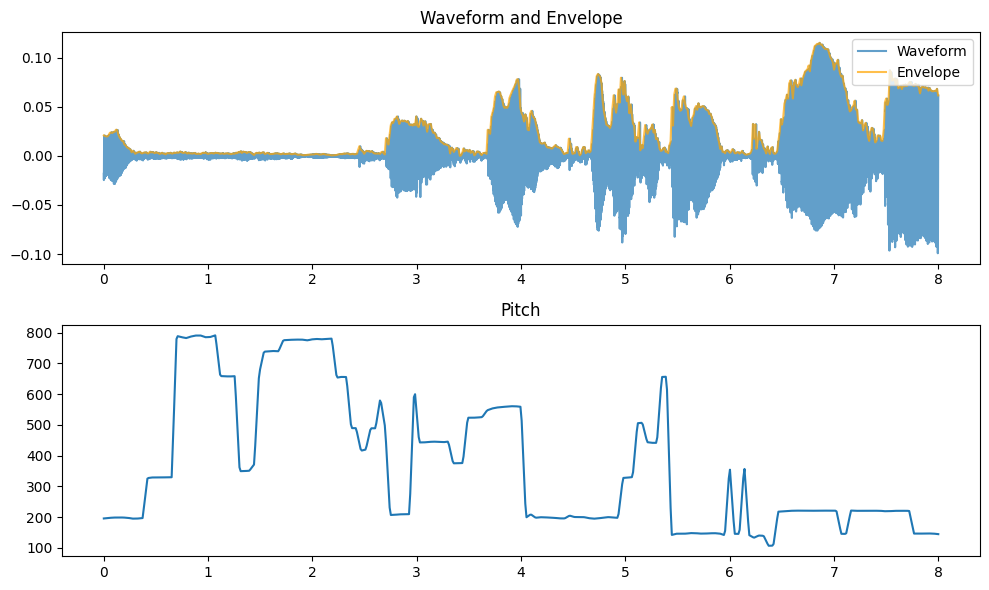

In [121]:
DATASET.plot_item(100)